In [223]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [224]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from datetime import datetime
from torchvision import datasets, models, transforms
from torchsummary import summary
from sklearn import metrics

## Carregar base Fashion MNIST para classificar usando Rede Neural

<p>Fashion-MNIST é um conjunto de dados desenvolvido pela Zalando Research como uma alternativa moderna ao conjunto de dados MNIST original. Ele compreende 70.000 imagens em tons de cinza categorizadas em 10 itens relacionados à moda. Cada imagem tem 28×28 pixels, fornecendo um formato uniforme para entrada do modelo de aprendizado de máquina. O conjunto de dados é dividido em um conjunto de treinamento de 60.000 imagens e um conjunto de teste de 10.000 imagens.



<img src="https://media.geeksforgeeks.org/wp-content/uploads/20240514130106/download-(8).png" alt="Drawing"  width="600"/>


As dez categorias no Fashion MNIST são:
<ul>
<li>Camiseta/top</li>
<li>Calça</li>
<li>Pulôver</li>
<li>Vestido</li>
<li>Casaco</li>
<li>Sandália</li>
<li>Camisa</li>
<li>Tênis</li>
<li>Bolsa</li>
<li>Bota de tornozelo</li>
</ul>
</p>

## Carrega o conjunto de treino

In [225]:
train_dataset = torchvision.datasets.FashionMNIST(
    root='.',
    train=True,
    transform=transforms.ToTensor(),
    download=True
)

## Carrega o conjunto de teste

In [226]:
test_dataset = torchvision.datasets.FashionMNIST(
    root='.',
    train=False,
    transform = transforms.ToTensor(),
    download=True
)

#### Implementar a função que particiona o conjunto de treino em treino e validação. A função recebe as etiquetas do train_dataset (train_dataset.targets) e as particiona em dois subconjuntos: treino e validação. A função deve retornar dois vetores com os índices dos amostras usadas para cada subconjunto.

In [227]:
def train_val_split(labels, perc = 0.8):
  # inseriri codigo
  train = []
  test = []
  for i in range(10):
    indices = np.where(labels == i)[0]
    np.random.shuffle(indices)
    train.extend(indices[:int(perc*len(indices))])
    test.extend(indices[int(perc*len(indices)):])


  return train, test

#### Retorna os índices com as amostras selecionadas para treino e validação

In [228]:
tr, vl = train_val_split(train_dataset.targets.numpy())
print(len(tr), len(vl) )

48000 12000


#### Apartir dos indices divide o dataset, que consta de imagem e seu respectivo rótulo, em os conjuntos de treino e validação

In [229]:
traindata = torch.utils.data.Subset(train_dataset, indices=torch.tensor(tr, dtype=torch.long))
valdata = torch.utils.data.Subset(train_dataset, indices=torch.tensor(vl, dtype=torch.long))

## Datalaloader usada para criar batches durante o treino

#### Definição dos dataloader dos três subconjuntos

In [230]:
# Data loader
# Util pq cria automáticamente batches durante o treino
# além de embaralhar os dados
batch_size = 128
train_loader = torch.utils.data.DataLoader(dataset = traindata,
    batch_size = batch_size,
    shuffle = True)
val_loader = torch.utils.data.DataLoader(dataset = valdata,
    batch_size = batch_size,
    shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
    batch_size = batch_size,
    shuffle = False)

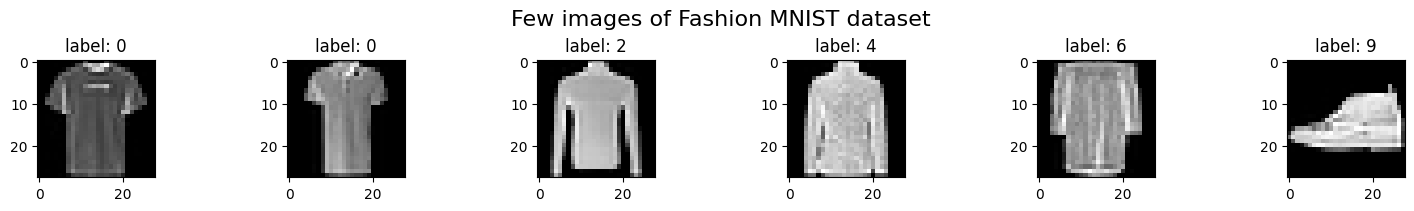

In [231]:
# verificação do funcionamento do dataloade
nb_digits_to_display = 6
f, ax = plt.subplots(1,nb_digits_to_display, figsize=(15,2), constrained_layout=True)
f.suptitle("Few images of Fashion MNIST dataset", fontsize=16)
for x, y in train_loader:
  for i in range(nb_digits_to_display):
    ax[i].imshow(x[i].numpy()[-1,:,:], cmap = 'gray')
    ax[i].set_title(f"label: {y[i].numpy()}")
  break

## Implementar uma CNN com as seguinte camadas:
<ul>
<li>1er grupo convolucional:</li>
  <ul>
  <li>Camada convolucional: 20 filtros, tamanho do filtro de $5 \times 5$, stride de 2 e com padding</li>
  <li>Função de ativação: ReLU</li>
  <li>Polling: filtro de $2 \times 2$, stride de 2</li>
  </ul>
<li>2do grupo convolucional:</li>
  <ul>
  <li>Camada convolucional: 50 filtros, tamanho do filtro de $3 \times 3$, stride de 1 e com padding</li>
  <li>Função de ativação: ReLU</li>
  <li>Polling: filtro de $2 \times 2$, stride de 2</li>
  </ul>
<li>3er grupo convolucional:</li>
  <ul>
  <li>Camada convolucional: 50 filtros, tamanho do filtro de $3 \times 3$, stride de 1 e com padding</li>
  <li>Função de ativação: ReLU</li>
  <li>Polling: filtro de $2 \times 2$, stride de 2</li>
  </ul>
<li>Grupo de classificação</li>
  <ul>
  <li>Regularização: dropout de 20%</li>
  <li>Camada fully connected com 400 neuronios</li>
  <li>Função de ativação: ReLU</li>
  <li>Regularização: dropout de 20%</li>
  <li>Camada fully connected com $n$ neuronios, onde $n$ é o número de classes</li>
  </ul>
</ul>

In [232]:
class Minhanet(nn.Module):
    def __init__(self, numChannels, classes):
        # chamar o construtor da classe Base (Pai)
        super(Minhanet, self).__init__()

        # definição das camadas convolucionais
        self.conv_layers = nn.Sequential(
            # primeiro grupo convolucional
            nn.Conv2d(in_channels = numChannels, out_channels=20, kernel_size=5, stride=1, padding = 2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # segundo grupo convolucional
            nn.Conv2d(in_channels = 20, out_channels=50, kernel_size=3, stride=1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # terceiro grupo convolucional
            nn.Conv2d(in_channels = 50, out_channels=50, kernel_size=3, stride=1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        # definiçao das camadas fully connected
        self.dense_layers = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=450, out_features=400),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(in_features=400, out_features=classes)
        )
    def forward(self, x):
        # inserir codigo
        out = self.conv_layers(x)
        out = out.view(out.size(0), -1)
        out = self.dense_layers(out)

        return out

In [233]:
def neuronios_convolucional(W, F, S, P):
    return int( (W-F+2*P)/S+1 )

In [234]:
def neuronios_pooling(W, F, S):
    return int( (W-F)/S+1 )

In [235]:
tam_conv1 = neuronios_pooling(neuronios_convolucional(28, 5, 1, 2), 2, 2)
tam_conv2 = neuronios_pooling(neuronios_convolucional(tam_conv1, 3, 1, 1), 2, 2)
tam_conv3 = neuronios_pooling(neuronios_convolucional(tam_conv2, 3, 1, 1), 2, 2)
print(tam_conv1)
print(tam_conv2)
print(tam_conv3)
print(tam_conv3*tam_conv3*50)

14
7
3
450


# Definição da função de treino

In [236]:
def fit(model, criterion, optimizer, train_loader, val_loader, epochs):
    train_losses = np.zeros( epochs )
    val_losses = np.zeros( epochs )

    for it in range(epochs):
        model.train()
        t0 = datetime.now()
        train_loss = []

        for inputs, targets in train_loader:
            # mover os dados para o GPU
            inputs, targets = inputs.to(device), targets.to(device)

            # zerar os gradientes
            optimizer.zero_grad()

            # forward pass
            outputs = model(inputs)

            loss = criterion(outputs, targets)

            # backward pass e optimiza
            loss.backward()
            optimizer.step()

            train_loss.append( loss.item() )

        train_loss = np.mean(train_loss)

        val_loss = []
        for inputs, targets in val_loader:
            model.eval()
            # mover os dados para o GPU
            inputs, targets = inputs.to(device), targets.to(device)

            # forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss.append(loss.item())
        val_loss = np.mean(val_loss)

        # salvar losses
        train_losses[it] = train_loss
        val_losses[it] = val_loss

        dt = datetime.now() - t0

        print(f'Epoch {it+1}/{epochs} Train Loss: {train_loss:.4f} Val Loss: {val_loss} Duracao: {dt}')

    return train_losses, val_losses

### Plotar a função de perda do treino e teste

In [237]:
def plot_losses(train_losses, test_losses):
    plt.plot(train_losses, label = 'train loss')
    plt.plot(test_losses, label = 'test loss')
    plt.legend()
    plt.show()

#### Módulo para avaliar o teste

In [238]:
def predict_module(model, test_loader):
    model.eval()
    predicted = np.empty((0), int)
    true_labels = np.empty((0), int)
    for inputs, targets in test_loader:
        # mover os dados para o GPU
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model(inputs)

        # obter a predição
        _, predictions = torch.max(outputs, 1)

        predicted = np.append(predicted, predictions.cpu())
        true_labels = np.append(true_labels, targets.cpu())

    return predicted, true_labels

#### Modulo para calcular a matriz de confusão

In [239]:
def matriz_confusao(true_labels, predicted, display_labels=[0,1,2]):
    matriz = metrics.confusion_matrix(true_labels, predicted)
    tot = np.sum(matriz, axis=1, keepdims=True)
    np.set_printoptions(precision=2)
    m_porc = matriz/tot
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=m_porc, display_labels=display_labels)
    disp.plot(values_format='.2f', xticks_rotation='vertical')
    plt.show()

In [240]:
# Instanciar a rede
model = Minhanet(numChannels = 1, classes = 10)


In [241]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

Minhanet(
  (conv_layers): Sequential(
    (0): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(20, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(50, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dense_layers): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=450, out_features=400, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=400, out_features=10, bias=True)
  )
)

#### Definição da função de perda (custo) e do otimizador

In [242]:
# Loss para varias classes
criterion = nn.CrossEntropyLoss()
# Optimizer
#optimizer = torch.optim.Adagrad( model.parameters() )
optimizer = torch.optim.SGD(model.parameters(),
                                    lr=0.001,
                                    momentum=0.9,
                                    weight_decay=1e-3)

Epoch 1/10 Train Loss: 2.2875 Val Loss: 2.2470855332435447 Duracao: 0:00:09.301077
Epoch 2/10 Train Loss: 1.6454 Val Loss: 0.9548896018494951 Duracao: 0:00:10.214013
Epoch 3/10 Train Loss: 0.9686 Val Loss: 0.8083527563734257 Duracao: 0:00:09.719451
Epoch 4/10 Train Loss: 0.8473 Val Loss: 0.7314096340473663 Duracao: 0:00:09.725974
Epoch 5/10 Train Loss: 0.7817 Val Loss: 0.6809429088805584 Duracao: 0:00:09.006277
Epoch 6/10 Train Loss: 0.7302 Val Loss: 0.636658861916116 Duracao: 0:00:09.734047
Epoch 7/10 Train Loss: 0.6924 Val Loss: 0.6222823902647546 Duracao: 0:00:09.965615
Epoch 8/10 Train Loss: 0.6644 Val Loss: 0.579027626425662 Duracao: 0:00:09.967035
Epoch 9/10 Train Loss: 0.6349 Val Loss: 0.5638608387176026 Duracao: 0:00:09.137310
Epoch 10/10 Train Loss: 0.6119 Val Loss: 0.5338264253545315 Duracao: 0:00:09.848640


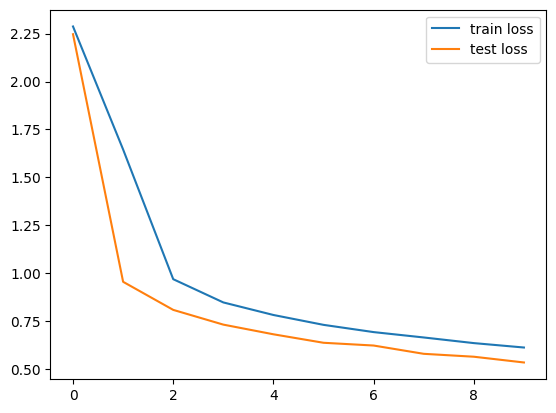

In [243]:
# treino da rede
train_losses, val_losses = fit(model, criterion, optimizer, train_loader, val_loader, epochs = 10)
plot_losses(train_losses, val_losses)

### Avaliando o conjunto de validação

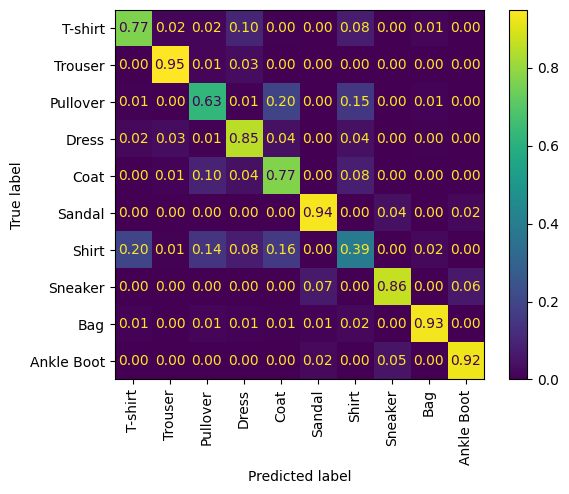

In [244]:
# Avaliando com o conjunto de teste
predicted, true_labels = predict_module(model, val_loader)
labels=[
    'T-shirt',
    'Trouser',
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle Boot',
]
matriz_confusao(true_labels, predicted, labels)

### Avaliando o conjunto de teste

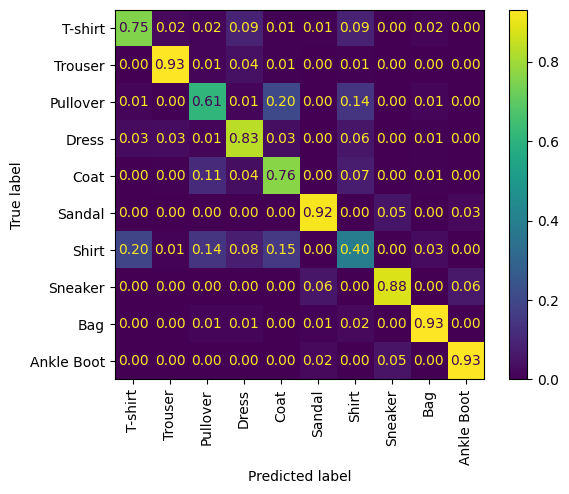

In [245]:
# Avaliando com o conjunto de teste
predicted, true_labels = predict_module(model, test_loader)
labels=[
    'T-shirt',
    'Trouser',
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle Boot',
]
matriz_confusao(true_labels, predicted, labels)